# Analysis notebook
Author: Evan Azevedo  
Company: Amberdata  
Blog Post: Large Txn's in the Mempool

In [346]:
# loading the packages
import os
import json
import requests
from tqdm import tqdm
from datetime import datetime, timedelta, timezone
import pytz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from dotenv import load_dotenv

In [347]:
# helper functions
def get_key():
    "Get the API key from an .env file"
    if ".env" not in os.listdir("../"):
        print("Configuring API Key...")
        key = input("Amberdata API Key: ")
        with open("../.env", "w") as f:
            f.write(f"AMBERDATA_API_KEY={key}\n")
    load_dotenv(verbose=True)
    return {
        "AMBERDATA_API_KEY": os.getenv("AMBERDATA_API_KEY")
    }

def get_response(url, headers=None, queryString=None):
    "Get the REST response from the specified URL"
    if not headers:
        headers = {'x-api-key': api_key["AMBERDATA_API_KEY"]}
    if queryString:
        response = requests.request("GET", url, headers=headers, params=queryString)
    else:
        response = requests.request("GET", url, headers=headers)
    response = json.loads(response.text)
    try:
        if response["title"] == "OK":
            return response["payload"]
    except Exception as e:
        return None

# let's load our api key
api_key = get_key()

## Reading the data
Now we get to read in the data from our Raspberry Pi. For now I am just plotting the raw values to see what kind of volume of transactions are going on.

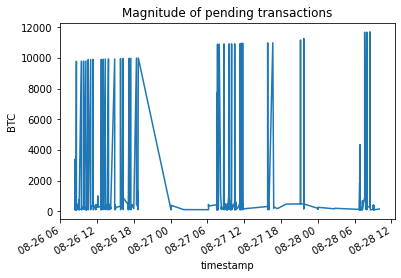

In [348]:
# read in the data from different sources
results = pd.read_csv("../data/results.csv", sep='; ', engine='python')

# get the value of BTC per pending txn
results["btc"] = results.value // 10**8
# convert to timestamp
results['timestamp'] = pd.to_datetime(results.timestamp, utc=True)

# remove duplicate transactions, keeping only the first
results = results.sort_values('timestamp').groupby('hash').first().reset_index().set_index('timestamp').reset_index()

# plot just to see if there are lots of whale activity
results.set_index('timestamp').btc.plot()
plt.title("Magnitude of pending transactions")
plt.ylabel("BTC")
plt.savefig("../plots/mag_pending.png")
plt.show()

In [349]:
results.btc.describe()

count      503.000000
mean      1033.846918
std       2613.269161
min        100.000000
25%        131.000000
50%        211.000000
75%        438.000000
max      11711.000000
Name: btc, dtype: float64

In [350]:
def exchange(x):
    if x.within:
        return "within"
    elif x.on:
        return "on"
    elif x.off:
        return "off"
    else:
        return "neither"

def post_hoc(addresses):
    "parses a list of addresses for a bitmex"
    addresses = addresses.strip('][').split(', ')
    for address in addresses:
        address = address.strip("''")
        if (address.startswith("3BMEX") or address.startswith("3BitMEX")):
            return True
        else:
            continue
    return False

results['off'] = results['from'].map(post_hoc)
results['on'] = results['to'].map(post_hoc)
results['within'] = results.off & results.on
results['status'] = results.apply(exchange, axis=1)

In [380]:
len(results[results.status != 'neither'])/len(results)*100

3.7773359840954273

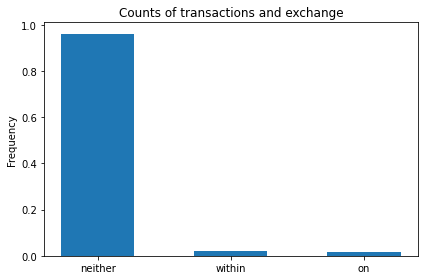

In [378]:
# get transactions on the exchange
data = results.status[results.status != 'neither'].value_counts()

labels = data.index.values
counts = data.values/data.sum()

x = np.arange(len(labels))  # the label locations
width = 0.55  # the width of the bars

fig, ax = plt.subplots()
p1 = plt.bar(x, counts, width)

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('Frequency')
plt.title('Counts of transactions and exchange')
plt.xticks(x, labels)
plt.tight_layout()
plt.savefig("../plots/transactions_on_exch.png")


## Getting OHLCV data

In [352]:
dfs = []
n_days = 3

for i in range(n_days):
    print(f"Iteration: {i}")
    # get the start and end dates in timestamps
    startDate = results.timestamp.min() + timedelta(i-1)
    endDate = startDate + timedelta(1)
    
    # convert to UNIX format
    startDate = str(round(startDate.timestamp()*10**3))
    endDate = str(round(endDate.timestamp()*10**3)-100)

    # the url for our endpoint
    url = "https://web3api.io/api/v2/market/ohlcv/btc_usd/historical"
    
    # our query
    querystring = {
        "timeInterval": "minutes", 
        "timeFormat": "iso",
        'startDate': startDate, 
        'endDate': endDate,
        "exchange": "bitstamp"
    }
    
    # the API key
    headers = {'x-api-key': api_key["AMBERDATA_API_KEY"]}

    # the response for our query
    payload = get_response(url, headers, querystring)
    
    # we save the OHLCV data
    bfx = payload['data']['bitstamp']

    # get the columns and make a dataframe
    columns = payload['metadata']['columns']
    bfx_df = pd.DataFrame(bfx, columns=columns)
    # append the dataframe to a list
    dfs.append(bfx_df)

# combine the several days of OHLCV data
ohlcv = pd.concat(dfs)

Iteration: 0
Iteration: 1
Iteration: 2


In [353]:
# save current data to csv
ohlcv.to_csv("../data/ohlcv.csv", index=False)
results.to_csv("../data/results_all.csv", index=False)

## Working with the OHLCV data

In [354]:
# read the data from our saved csvs
ohlcv = pd.read_csv("../data/ohlcv.csv")
results = pd.read_csv("../data/results_all.csv")

# change the UNIX timestamp to human readable format and set it as index
results["timestamp"] = pd.to_datetime(results.timestamp, utc=True)

# unify the timestamp format and set as index
ohlcv["timestamp"] = pd.to_datetime(ohlcv.timestamp)

# drop OHL from the dataframe
ohlcv.drop(['open', 'high', 'low'], axis=1, inplace=True)

# select only data from our date range
ohlcv = ohlcv[(ohlcv.timestamp <= results.timestamp.max()) & (ohlcv.timestamp >= results.timestamp.min())]

# set timestamp as index
ohlcv.set_index("timestamp", inplace=True)

### Adding USD to Pending txns
We would like to add the value of Bitcoin to our results DataFrame, so we can see the value of the transactions in USD.

In [355]:
# add a column of timestamps rounded to the minute
results["ts_minute"] = results.timestamp.dt.round('1min')

# rename the ohlcv column for joining
ohlcv_min = ohlcv.reset_index().rename({"timestamp": "ts_minute"}, axis=1)

# join the close column to the results dataframe
df_merged = pd.merge(results, ohlcv_min, on = "ts_minute", how='left').dropna()

# create the usd value column
df_merged["usd"] = df_merged.value/10**8 * df_merged.close

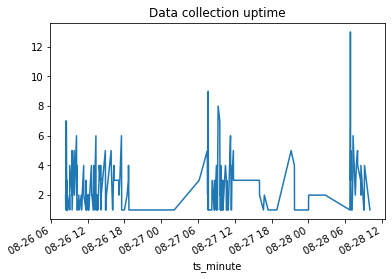

In [356]:
results.groupby('ts_minute').count().value.plot()
plt.title("Data collection uptime")
plt.savefig("../plots/uptime.png")

## Plotting exchange activity on price

In [357]:
# display the result, sorted by the largest transactions
# sort the values by increasing dollar amounts and
# save only transactions related to BitMEX
df_exch = df_merged.sort_values("usd", ascending=False).query("status != 'neither'")

In [358]:
df_exch

,timestamp,hash,from,to,value,exchange,btc,off,on,within,status,ts_minute,close,volume,usd
247,2020-08-26 08:25:05.010777+00:00,7e7a0509e41d5052d1a7205d708288f6bfa0012ebb3c4f...,"['3BMEXwJHzyiQrGs9rfN1MffRueSVsdFTJv', '3BMEXw...","['3Ba1TMW952RKDGjMk3f7DsVibWqoZb9nqd', '3BMEXw...",340072686735,0,3400,True,True,True,within,2020-08-26 08:25:00+00:00,11354.50,2.953804,3.861355e+07
502,2020-08-26 08:27:22.509002+00:00,fd5f4b291531299d97eb2f868eac9f250293263a309b50...,"['3BMEXDGqNDKAdso1q36AbLpGcpZggvyzd5', '3BMEXD...","['1LJxT8ET4AtJzJpL4CCZ9mz8pUf2SopF8z', '3BMEXD...",115007550202,0,1150,True,True,True,within,2020-08-26 08:27:00+00:00,11356.00,3.346410,1.306026e+07
46,2020-08-28 06:56:19.188320+00:00,1c16ccc87595a6e7eac697177b7208eb16d084df17f595...,"['3BMEXieYQzraheo86uFyXWVWcQidoLYqFk', '3BMEXi...","['1KDM3vtx1X5aJLZQi7j6qjC6qxu4PrShnw', '3BMEXi...",33006074419,3,330,True,True,True,within,2020-08-28 06:56:00+00:00,11432.45,1.151286,3.773403e+06
59,2020-08-28 07:48:40.031551+00:00,2591ce8b5929ef3d40896cef8ecf19547294f988e1cd1b...,"['19PaaCGTEJbGTTnMCbBNGhYPULCwjXBj19', '1NF89H...","['36dWEpF1jt4th2gsMEmJhUPHaoBL2SGVSx', '354MKj...",18586699200,2,185,False,True,False,on,2020-08-28 07:49:00+00:00,11380.16,32.457989,2.115196e+06
236,2020-08-27 11:46:31.243475+00:00,79267164bc1d33bcce5fe957fd4d59a799db56579aeb4d...,"['1NDyJtNTjmwk5xPNhjgAMu4HDHigtobu1s', '1NDyJt...","['3BMEXz58J7k1CL6MxZh62vdPrNnFMchzBR', '3Dadw4...",17669731513,2,176,False,True,False,on,2020-08-27 11:47:00+00:00,11368.95,2.069261,2.008863e+06
97,2020-08-26 08:27:22.217404+00:00,35432bbb52acc1774443bf03a6629ec0db63e73dfb9a46...,"['3BMEXs2epEfMx1WVfxCfDEKkn9Snqhf9xc', '3BMEXs...","['1MUmaGcu77W7eKTbACivBSoFAdwxuhPYWX', '3BMEXs...",16791877894,0,167,True,True,True,within,2020-08-26 08:27:00+00:00,11356.00,3.346410,1.906886e+06
500,2020-08-27 11:21:34.982304+00:00,fb523746d951df374f3cdfee71c426cdf4cd12f57bdea4...,"['1NDyJtNTjmwk5xPNhjgAMu4HDHigtobu1s', '1NDyJt...","['3BMEX2kzugNmCJwokxHtMWPyNEFBkwDsJN', '1BGV81...",15732013514,2,157,False,True,False,on,2020-08-27 11:22:00+00:00,11352.08,0.761693,1.785911e+06
74,2020-08-27 07:40:48.169151+00:00,2ca84c6df7451e4e9807c533cd81bbef6d4f5f6f05a3a1...,"['1NDyJtNTjmwk5xPNhjgAMu4HDHigtobu1s', '1NDyJt...","['1CEbiHaUMZEr8oCx6H3vqEk8qgPx4Y983b', 'bc1qy7...",15288090280,2,152,False,True,False,on,2020-08-27 07:41:00+00:00,11402.83,1.050857,1.743275e+06
351,2020-08-26 08:27:22.863777+00:00,aebafbbfe56fc101af27f90dfdf50ceab5dfdbfdf76267...,"['3BMEXGMRaa8qdwfoiVhQNJNm9478PFQMX3', '3BMEXG...","['14NNn4sp9ESLSSdASFzWUgQtJhwAKRcwe6', '3BMEXG...",15029153251,0,150,True,True,True,within,2020-08-26 08:27:00+00:00,11356.00,3.346410,1.706711e+06
2,2020-08-27 07:36:11.533797+00:00,01f9b5c099252a4ea0f85de103082444b6037de7d77e36...,['34LAFMWP3ca3ujmHqLVz3wmz6YBpcFTCHe'],"['3BMEXTEEyc6JK9XqjLbvNwyWvSheXCkZve', '3AHf27...",14897961634,2,148,False,True,False,on,2020-08-27 07:36:00+00:00,11395.28,0.048974,1.697664e+06


/Users/evanazevedo/.virtualenvs/amberdata/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Legend does not support 0 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


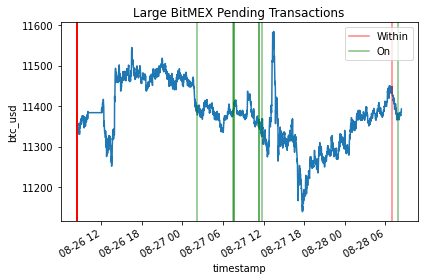

In [359]:
# plotting the time series of bitcoin price
ohlcv.close.plot()

# add a red line when a large pending transaction occured
lines = [0]*3
for i in range(len(df_exch)):
    txn = df_exch.iloc[i]
    # set the color according to the status
    if txn.status == 'within':
        l = plt.axvline(txn[0], color='r', alpha=0.5)
        lines[0] = l
    elif txn.status == 'on':
        l = plt.axvline(txn[0], color='g', alpha=0.5)
        lines[1] = l
    elif txn.status == 'off':
        l = plt.axvline(txn[0], color='b', alpha=0.5)
        lines[2] = l

plt.title("Large BitMEX Pending Transactions")
plt.ylabel("btc_usd")
plt.legend(lines, ("Within", "On", "Off"))
plt.tight_layout()
plt.savefig("../plots/large_bitmex_flows.png")
plt.show()

/Users/evanazevedo/.virtualenvs/amberdata/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Legend does not support 0 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


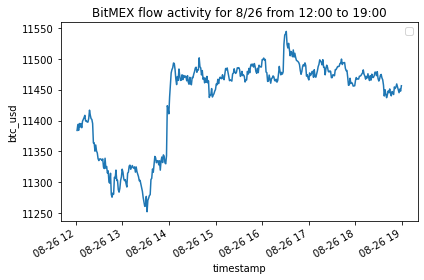

In [360]:
# the start and end timestamps
start, end = datetime(2020, 8, 26, 12, 0, 0, tzinfo=pytz.UTC), datetime(2020, 8, 26, 19, 0, 0, tzinfo=pytz.UTC)

# plotting the price
ohlcv[(ohlcv.index > start) & (ohlcv.index < end)].close.plot()

# adding a line for bitmex flows
lines = [0]*2
for i in range(len(df_exch)):
    txn = df_exch.iloc[i]
    # grabbing the timestamp in minutes
    ts = txn[0]
    # plotting the vertical line
    if ts > start and ts < end:
        if txn.status == 'on':
            l = plt.axvline(txn[0], color='g', alpha=0.5)
            lines[0] = l
        elif txn.status == 'off':
            l = plt.axvline(txn[0], color='b', alpha=0.5)
            lines[1] = l
    
# add an appropriate title
plt.title(f"BitMEX flow activity for {start.month}/{start.day} from {start.hour}:{start.minute}0 to {end.hour}:{end.minute}0")
# label the y axis
plt.ylabel("btc_usd")
plt.legend(lines, ("On", "Off"))
plt.tight_layout()
# save the figure
plt.savefig("../plots/flow_zoom_in1.png")

In [361]:
df_largest = df_exch.iloc[:, [0, 1, 2, 5, 7]].reset_index(drop=True).head(10)

df_largest

,timestamp,hash,from,exchange,off
0,2020-08-26 08:25:05.010777+00:00,7e7a0509e41d5052d1a7205d708288f6bfa0012ebb3c4f...,"['3BMEXwJHzyiQrGs9rfN1MffRueSVsdFTJv', '3BMEXw...",0,True
1,2020-08-26 08:27:22.509002+00:00,fd5f4b291531299d97eb2f868eac9f250293263a309b50...,"['3BMEXDGqNDKAdso1q36AbLpGcpZggvyzd5', '3BMEXD...",0,True
2,2020-08-28 06:56:19.188320+00:00,1c16ccc87595a6e7eac697177b7208eb16d084df17f595...,"['3BMEXieYQzraheo86uFyXWVWcQidoLYqFk', '3BMEXi...",3,True
3,2020-08-28 07:48:40.031551+00:00,2591ce8b5929ef3d40896cef8ecf19547294f988e1cd1b...,"['19PaaCGTEJbGTTnMCbBNGhYPULCwjXBj19', '1NF89H...",2,False
4,2020-08-27 11:46:31.243475+00:00,79267164bc1d33bcce5fe957fd4d59a799db56579aeb4d...,"['1NDyJtNTjmwk5xPNhjgAMu4HDHigtobu1s', '1NDyJt...",2,False
5,2020-08-26 08:27:22.217404+00:00,35432bbb52acc1774443bf03a6629ec0db63e73dfb9a46...,"['3BMEXs2epEfMx1WVfxCfDEKkn9Snqhf9xc', '3BMEXs...",0,True
6,2020-08-27 11:21:34.982304+00:00,fb523746d951df374f3cdfee71c426cdf4cd12f57bdea4...,"['1NDyJtNTjmwk5xPNhjgAMu4HDHigtobu1s', '1NDyJt...",2,False
7,2020-08-27 07:40:48.169151+00:00,2ca84c6df7451e4e9807c533cd81bbef6d4f5f6f05a3a1...,"['1NDyJtNTjmwk5xPNhjgAMu4HDHigtobu1s', '1NDyJt...",2,False
8,2020-08-26 08:27:22.863777+00:00,aebafbbfe56fc101af27f90dfdf50ceab5dfdbfdf76267...,"['3BMEXGMRaa8qdwfoiVhQNJNm9478PFQMX3', '3BMEXG...",0,True
9,2020-08-27 07:36:11.533797+00:00,01f9b5c099252a4ea0f85de103082444b6037de7d77e36...,['34LAFMWP3ca3ujmHqLVz3wmz6YBpcFTCHe'],2,False


/Users/evanazevedo/.virtualenvs/amberdata/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Legend does not support 0 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


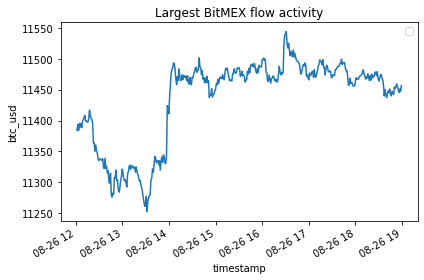

In [362]:
# the start and end timestamps
start, end = datetime(2020, 8, 26, 12, 0, 0, tzinfo=pytz.UTC), datetime(2020, 8, 26, 19, 0, 0, tzinfo=pytz.UTC)

# plotting the price
ohlcv[(ohlcv.index > start) & (ohlcv.index < end)].close.plot()

# adding a line for bitmex flows
lines = [0]*3
for i in range(len(df_largest)):
    txn = df_largest.iloc[i]
    # grabbing the timestamp in minutes
    ts = txn[0]
    # plotting the vertical line
    if ts > start and ts < end:
        if txn.status == 'on':
            l = plt.axvline(txn[0], color='g', alpha=0.5)
            lines[0] = l
        elif txn.status == 'off':
            l = plt.axvline(txn[0], color='b', alpha=0.5)
            lines[1] = l
    
# add an appropriate title
plt.title(f"Largest BitMEX flow activity")
# label the y axis
plt.ylabel("btc_usd")
plt.legend(lines, ("On", "Off"))
plt.tight_layout()
# save the figure
plt.savefig("../plots/flow_zoom_in_largest.png")

/Users/evanazevedo/.virtualenvs/amberdata/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Legend does not support 0 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


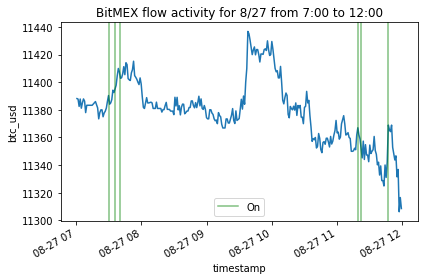

In [363]:
# the start and end timestamps
start, end = datetime(2020, 8, 27, 7, 0, 0, tzinfo=pytz.UTC), datetime(2020, 8, 27, 12, 0, 0, tzinfo=pytz.UTC)

# plotting the price
ohlcv[(ohlcv.index > start) & (ohlcv.index < end)].close.plot()

# adding a line for bitmex flows
lines = [0]*3
for i in range(len(df_exch)):
    txn = df_exch.iloc[i]
    # grabbing the timestamp in minutes
    ts = txn[0]
    # plotting the vertical line
    if ts > start and ts < end:
        if txn.status == 'within':
            l = plt.axvline(txn[0], color='r', alpha=0.5)
            lines[0] = l
        elif txn.status == 'on':
            l = plt.axvline(txn[0], color='g', alpha=0.5)
            lines[1] = l
        elif txn.status == 'off':
            l = plt.axvline(txn[0], color='b', alpha=0.5)
            lines[2] = l
    
# add an appropriate title
plt.title(f"BitMEX flow activity for {start.month}/{start.day} from {start.hour}:{start.minute}0 to {end.hour}:{end.minute}0")
# label the y axis
plt.ylabel("btc_usd")
plt.legend(lines, ("Within", "On", "To"))
plt.tight_layout()
# save the figure
plt.savefig("../plots/flow_zoom_in2.png")

## Which Txn's went through?
Let's see first if our big $(>\$78 m)$ transaction went through. We can check this easily enough since we recorded the transaction hash, the timestamp, and the address as well as the transaction size. We will be using the Amberdata [transaction](https://docs.amberdata.io/reference#get-address-transactions) endpoint.

In [364]:
df_exch.timestamp.max()

Timestamp('2020-08-28 07:48:40.031551+0000', tz='UTC')

In [371]:
def parse_addresses(i: int = 0, n: int = 0) -> str:
    """Returns the address from record i in position n"""
    # parse the list of addresses
    address_list = df_exch.iloc[i, 2].split("['")[-1].split("']")[0]
    return address_list.split("', '")[n]

In [366]:
# the top transaction number we consider
i = 0
# the sender's address
sender = parse_addresses(i)
# the transaction hash
txn_hash = df_exch.iloc[i, 3]

url = f"https://web3api.io/api/v2/addresses/{sender}/transactions"

# format the date string for start and endtimes
start = str(datetime(2020, 8, 26, 8, 25, 0).strftime("%Y-%m-%dT%H:%M:%S.000Z"))
end = str(datetime.today().strftime("%Y-%m-%dT%H:%M:%S.000Z"))

# setting the start and end time and the number of records to return
querystring = {"startDate": start,
               "endDate": end,
               "page":"0",
               "size":"100"}

# headers: getting data from btc mainnet
headers = {
    'x-amberdata-blockchain-id': "bitcoin-mainnet",
    'x-api-key': api_key["AMBERDATA_API_KEY"]
}

# get the response
response = get_response(url, headers, querystring)

sent_txn = None
# parse the records to see if the transaction was posted
for record in response["records"]:
    # if the transction hash is the same as the posted hash
    if record['hash']==txn_hash:
        # show the record
        sent_txn = record
        print(sent_txn)

# display if we found the transaction or not
if sent_txn:
    print(sent_txn)
else:
    print("Transaction not completed.")

Transaction not completed.


As we can see, the large transaction did not end up going through. It's possible that this was just a way to introduce false volume at the bottom of the order book. Now, let's iterate through and see if any of the top $N$ transactions went through.

In [376]:
sent_txns = []

for i in tqdm(range(len(df_exch))):
    # the sender's address
    sender = parse_addresses(i)
    # the transaction hash
    txn_hash = df_exch.iloc[i, 1]

    url = f"https://web3api.io/api/v2/addresses/{sender}/transactions"

    # format the date string for start and endtimes
    start = str(datetime(2020, 8, 26, 8, 25, 0).strftime("%Y-%m-%dT%H:%M:%S.000Z"))
    end = str(datetime.today().strftime("%Y-%m-%dT%H:%M:%S.000Z"))

    # setting the start and end time and the number of records to return
    querystring = {"startDate": start,
                   "endDate": end,
                   "page":"0",
                   "size":"1000"}

    # headers: getting data from btc mainnet
    headers = {
        'x-amberdata-blockchain-id': "bitcoin-mainnet",
        'x-api-key': api_key["AMBERDATA_API_KEY"]
    }

    # get the response
    response = get_response(url, headers, querystring)

    # parse the records to see if the transaction was posted
    try:
        for record in response["records"]:
            # if the transction hash is the same as the posted hash
            if record['hash']==txn_hash:
                # save the record
                sent_txns.append(record)
    except TypeError:
        continue

100%|██████████| 19/19 [01:36<00:00,  5.10s/it]


In [377]:
print(f"Number of completed transactions: {len(sent_txns)}\nTotal transactions: {len(df_exch)}\nPercent completed: {len(sent_txns)/len(df_exch)}")

Number of completed transactions: 16
Total transactions: 19
Percent completed: 0.8421052631578947
